In [14]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Def various functions for labels transformation and common sense error

In [15]:
def periodic_trans(time):
    time_period = np.round([np.cos(time[:,0]/12*2*np.pi),
                            np.sin(time[:,0]/12*2*np.pi),
                            np.cos(time[:,1]/60*2*np.pi),
                            np.sin(time[:,1]/60*2*np.pi)],5)
    return time_period.T

def period_to_hrmin(period_time,hr_or_min):
    # convert period to clk time (either hr or min, for hr use 12, for min use 60 for hr_or_min)
    time_y_rad = np.arctan2(period_time[:,1],period_time[:,0])
    time_y = (time_y_rad < 0)*2*np.pi + time_y_rad
    time_clk = time_y/2/np.pi*hr_or_min
    return np.round(time_clk)

def period_to_clk(period_time):
    return np.array([period_to_hrmin(period_time[:,:2],12),
                     period_to_hrmin(period_time[:,2:],60)]).T

# ty1 = period_to_clk(train_ty_period)
# test_ty_period = periodic_trans(test_ty)

def calculate_angle(vec1, vec2):
    dot_product = np.sum(vec1 * vec2, axis=1)
    mag1 = np.linalg.norm(vec1, axis=1)
    mag2 = np.linalg.norm(vec2, axis=1)
    cos_theta = dot_product / (mag1 * mag2)
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to avoid domain errors
    return angle

def common_sense_err(test_y,pred_y):
    hr_angle = calculate_angle(test_y[:,:2],pred_y[:,:2])
    min_angle = calculate_angle(test_y[:,2:],pred_y[:,2:])
    hr_diff = hr_angle/2/np.pi*12
    min_diff = min_angle/2/np.pi*60
    return np.round(np.array([hr_diff,min_diff]).T)

def single_angle_trans(clk_time):
    time_rad = clk_time[:,0]/12*2*np.pi + clk_time[:,1]/60*np.pi/6
    time_per = np.array(np.round([np.cos(time_rad),
                                  np.sin(time_rad)],5)).T
    return time_per

def s_ang_to_clk(s_angle):
    y_rad = np.arctan2(s_angle[:,1],s_angle[:,0])
    y_rad2 = (y_rad < 0)*2*np.pi + y_rad
    y_clk = y_rad2/2/np.pi*12
    return np.array([y_clk.astype(int),np.round(y_clk%1*60)]).T

def common_sense_err2(test_y,pred_y):
    sa1 = single_angle_trans(pred_y)
    sa2 = single_angle_trans(test_y)
    sa_diff = calculate_angle(sa1,sa2)
    hr_diff = sa_diff//(np.pi/6)
    min_diff = np.round((sa_diff%(np.pi/6)*6*60/np.pi))
    return np.array([hr_diff,min_diff]).T

# train_ty_period = periodic_trans(train_ty)
# print(train_ty_period[:10])
# train_ty_period[:,2:]

# y1 = period_to_hrmin(train_ty_period[:,2:],60)
# tt1 = test_ty_period[:3]
# tt2 = train_ty_period[:3]
# train_ty[:10]
# calculate_angle(tt1[:,:2],tt2[:,:2])
# print(common_sense_err(tt1,tt2))

# tt3 = single_angle_trans(train_ty[:3])
# tt4 = single_angle_trans(test_ty[:3])
# sa1 = calculate_angle(tt3,tt4)

# common_sense_err2(train_ty[:3],test_ty[:3])

Importing Data

In [16]:
time_x = np.load('s_images.npy')
time_y = np.load('s_labels.npy')
train_tx, test_tx, train_ty, test_ty = train_test_split(time_x, time_y, test_size=0.1, random_state=42)
train_ty[:10],test_ty[:10]
train_ty_period = periodic_trans(train_ty)
test_ty_period = periodic_trans(test_ty)
train_ty_period[:,2:]


array([[-0.97815,  0.20791],
       [-0.91355, -0.40674],
       [ 0.97815, -0.20791],
       ...,
       [-0.86603, -0.5    ],
       [-0.91355, -0.40674],
       [-0.99452, -0.10453]])

In [17]:
train_tx[:,1]
train_ty

array([[11, 28],
       [ 6, 34],
       [ 9, 58],
       ...,
       [ 3, 35],
       [ 0, 34],
       [10, 31]])

Model Type 5.1: Multi-head with scaled regression

In [18]:
K.clear_session()


input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(1,name='min_y')(min_y)

model_time_MH1 = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time_MH1.summary()
print(model_time_MH1)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_MH1.compile(optimizer=optimizer,
                       loss={'hr_y': loss_fn, 'min_y': 'mse'},
                       metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time_MH1 = model_time_MH1.fit(train_tx, {'hr_y': train_ty[:,0], 'min_y': train_ty[:,1]/59},
                                    epochs = 30, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping, reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 75, 75, 1) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 73, 73,    │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 73, 73,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 36, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 34, 34,    │     36,896 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 34,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 15, 15,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 7, 7, 64)  │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 877,997 (3.35 MB)

 Trainable params: 877,549 (3.35 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - hr_y_accuracy: 0.0843 - hr_y_loss: 2.5736 - loss: 7.6968 - min_y_loss: 1.0282 - min_y_mae: 0.4752 - val_hr_y_accuracy: 0.0778 - val_hr_y_loss: 2.4842 - val_loss: 3.8351 - val_min_y_loss: 0.2044 - val_min_y_mae: 0.3723 - learning_rate: 0.0010
Epoch 2/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - hr_y_accuracy: 0.0835 - hr_y_loss: 2.4850 - loss: 3.4988 - min_y_loss: 0.0896 - min_y_mae: 0.2499 - val_hr_y_accuracy: 0.0753 - val_hr_y_loss: 2.4847 - val_loss: 3.0574 - val_min_y_loss: 0.0793 - val_min_y_mae: 0.2316 - learning_rate: 0.0010
Epoch 3/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - hr_y_accuracy: 0.0821 - hr_y_loss: 2.4850 - loss: 2.9834 - min_y_loss: 0.0800 - min_y_mae: 0.2285 - val_hr_y_accuracy: 0.0778 - val_hr_y_loss: 2.4906 - val_loss: 2.8308 - val_min_y_loss: 0.0777 - val_min_y_mae: 0.2265 - learning_rate: 0.0010
Epoch 4/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - hr_y_accuracy: 

57/57 - 0s - 2ms/step - hr_y_accuracy: 0.6233 - hr_y_loss: 0.9550 - loss: 1.1255 - min_y_loss: 0.0320 - min_y_mae: 0.1187


[1.1255059242248535,
 0.9549936056137085,
 0.03197813406586647,
 0.6233333349227905,
 0.11869477480649948]

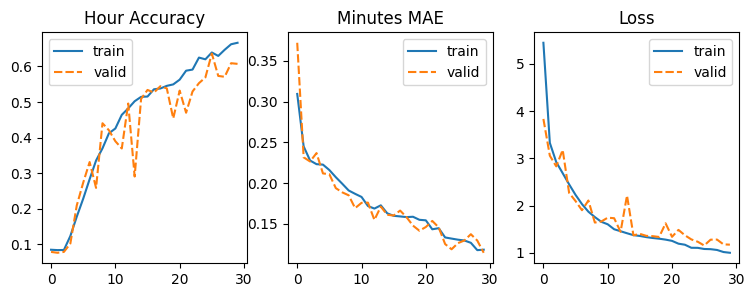

In [49]:
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time_MH1.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time_MH1.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time_MH1.history['min_y_mae']
min_mae_df['valid'] = his_model_time_MH1.history['val_min_y_mae']
loss_df['train'] = his_model_time_MH1.history['loss']
loss_df['valid'] = his_model_time_MH1.history['val_loss']
fig, axs = plt.subplots(ncols=3,figsize=(9,3))
sns.lineplot(hr_acc_df,ax=axs[0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[2]).set_title("Loss")
model_time_MH1.evaluate(test_tx,  {'hr_y': test_ty[:, 0], 'min_y': test_ty[:, 1] / 59}, verbose=2)

In [20]:
print(test_ty[0:10])
pred_hr_MH1,pred_min_MH1 = model_time_MH1.predict(test_tx)
hr_MH1 = np.argmax(tf.nn.softmax(pred_hr_MH1),axis=1)
min_MH1 = np.round(pred_min_MH1*60).flatten()
hr_MH1[:10],min_MH1[:10]
pred_MH1 = np.array([hr_MH1,min_MH1]).T
pred_MH1
np.mean(common_sense_err2(test_ty,pred_MH1),axis = 0)

[[ 1 42]
 [ 4 59]
 [ 6  8]
 [ 3 38]
 [ 0 29]
 [ 7 50]
 [ 0 34]
 [ 4 50]
 [ 7 39]
 [ 7 44]]
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


array([ 0.28111111, 16.21555556])

Multi-head with periodic transformation

In [21]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(2,name='min_y')(min_y)

model_time_MH2 = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time_MH2.summary()
print(model_time_MH2)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_MH2.compile(optimizer=optimizer,
                       loss={'hr_y': loss_fn, 'min_y': 'mse'},
                       metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time_MH2 = model_time_MH2.fit(train_tx, {'hr_y': train_ty[:,0], 'min_y': train_ty_period[:,2:]},
                                    epochs = 30, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 75, 75, 1) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 73, 73,    │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 73, 73,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 36, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 34, 34,    │     36,896 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 34,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 15, 15,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 7, 7, 64)  │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 878,062 (3.35 MB)

 Trainable params: 877,614 (3.35 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - hr_y_accuracy: 0.0804 - hr_y_loss: 2.5561 - loss: 6.9322 - min_y_loss: 0.8026 - min_y_mae: 0.7000 - val_hr_y_accuracy: 0.0846 - val_hr_y_loss: 2.4849 - val_loss: 3.5899 - val_min_y_loss: 0.4458 - val_min_y_mae: 0.5998 - learning_rate: 0.0010
Epoch 2/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - hr_y_accuracy: 0.0991 - hr_y_loss: 2.4679 - loss: 3.3262 - min_y_loss: 0.3472 - min_y_mae: 0.4980 - val_hr_y_accuracy: 0.1648 - val_hr_y_loss: 2.2637 - val_loss: 2.8505 - val_min_y_loss: 0.2946 - val_min_y_mae: 0.4546 - learning_rate: 0.0010
Epoch 3/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - hr_y_accuracy: 0.1729 - hr_y_loss: 2.1860 - loss: 2.7539 - min_y_loss: 0.2952 - min_y_mae: 0.4516 - val_hr_y_accuracy: 0.2037 - val_hr_y_loss: 2.0720 - val_loss: 2.6010 - val_min_y_loss: 0.2711 - val_min_y_mae: 0.4323 - learning_rate: 0.0010
Epoch 4/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - hr_y_accuracy: 

57/57 - 0s - 9ms/step - hr_y_accuracy: 0.8822 - hr_y_loss: 0.3254 - loss: 0.5702 - min_y_loss: 0.0341 - min_y_mae: 0.1386


[0.5701673030853271,
 0.3254165053367615,
 0.034105271100997925,
 0.8822222352027893,
 0.13863743841648102]

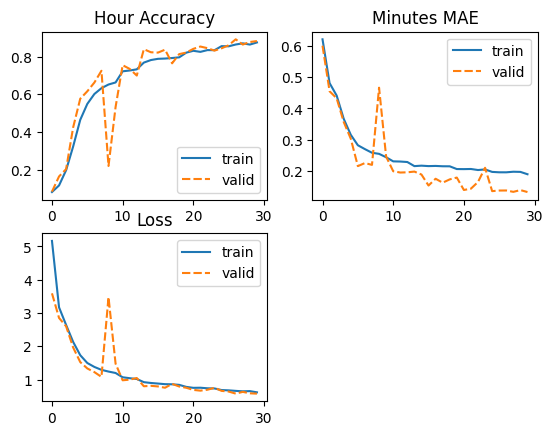

In [ ]:
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time_MH2.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time_MH2.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time_MH2.history['min_y_mae']
min_mae_df['valid'] = his_model_time_MH2.history['val_min_y_mae']
loss_df['train'] = his_model_time_MH2.history['loss']
loss_df['valid'] = his_model_time_MH2.history['val_loss']
fig, axs = plt.subplots(ncols=3,figsize=(9,3))
sns.lineplot(hr_acc_df,ax=axs[0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[2]).set_title("Loss")
model_time_MH2.evaluate(test_tx,  {'hr_y': test_ty[:, 0], 'min_y':test_ty_period[:,2:] }, verbose=2)

In [23]:
# print(test_ty[0:10])
pred_hr_MH2,pred_min_MH2 = model_time_MH2.predict(test_tx)
pred_hr_MH2[:10],pred_min_MH2[:10]
hr_MH2 = np.argmax(tf.nn.softmax(pred_hr_MH2),axis=1)
min_MH2 = period_to_hrmin(pred_min_MH2,60)
hr_MH2[:10],min_MH2[:10]
pred_MH2 = np.array([hr_MH2,min_MH2]).T
print(test_ty[:3],pred_MH2[:3])
np.mean(common_sense_err2(test_ty,pred_MH2),axis = 0)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 1. 45.]
 [ 4. 59.]
 [ 6. 10.]]


array([0.05555556, 5.51055556])

Single Angle Periodic transformation

In [24]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_P1 = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P1.summary()
print(model_time_P1)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P1.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P1 = model_time_P1.fit(train_tx, single_angle_trans(train_ty),
                                    epochs = 30, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,490 (1.78 MB)

 Trainable params: 467,042 (1.78 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 2.9793 - mae: 0.7082 - val_loss: 1.0130 - val_mae: 0.6101 - learning_rate: 0.0010
Epoch 2/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.7787 - mae: 0.5162 - val_loss: 0.5198 - val_mae: 0.4915 - learning_rate: 0.0010
Epoch 3/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.3961 - mae: 0.4016 - val_loss: 0.2388 - val_mae: 0.3097 - learning_rate: 0.0010
Epoch 4/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2426 - mae: 0.3127 - val_loss: 0.1972 - val_mae: 0.2971 - learning_rate: 0.0010
Epoch 5/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1763 - mae: 0.2665 - val_loss: 0.1196 - val_mae: 0.2024 - learning_rate: 0.0010
Epoch 6/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1454 - mae: 0.2469 - val_loss: 0.1061 - val_mae: 0.1999 - learning_rate: 0.0010
Epoch 7/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1350 - mae: 0.2400 - val_loss: 0.1479 - val_

57/57 - 0s - 5ms/step - loss: 0.0348 - mae: 0.1070


[0.03480199724435806, 0.10696332156658173]

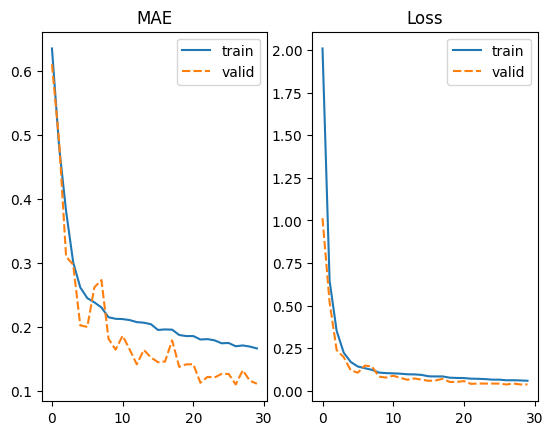

In [ ]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P1.history['mae']
mae_df['valid'] = his_model_time_P1.history['val_mae']
loss_df['train'] = his_model_time_P1.history['loss']
loss_df['valid'] = his_model_time_P1.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P1.evaluate(test_tx,  single_angle_trans(test_ty), verbose=2)

In [26]:
# print(test_ty[0:10])
pred_y_P1 = model_time_P1.predict(test_tx)
pred_P1 = s_ang_to_clk(pred_y_P1)
print(test_ty[:3],pred_P1[:3])
np.mean(common_sense_err2(test_ty,pred_P1),axis = 0)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 1. 40.]
 [ 4. 55.]
 [ 5. 53.]]


array([8.33333333e-03, 1.33944444e+01])

Periodic transformation

In [27]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(4)(x)

model_time_P2 = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P2.summary()
print(model_time_P2)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P2.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P2 = model_time_P2.fit(train_tx, train_ty_period,
                                    epochs = 30, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,620 (1.78 MB)

 Trainable params: 467,172 (1.78 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 2.5324 - mae: 0.6845 - val_loss: 0.7950 - val_mae: 0.6309 - learning_rate: 0.0010
Epoch 2/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.6694 - mae: 0.5906 - val_loss: 0.3920 - val_mae: 0.4622 - learning_rate: 0.0010
Epoch 3/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.3999 - mae: 0.4783 - val_loss: 0.3453 - val_mae: 0.4649 - learning_rate: 0.0010
Epoch 4/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.3476 - mae: 0.4628 - val_loss: 0.4189 - val_mae: 0.5085 - learning_rate: 0.0010
Epoch 5/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.3321 - mae: 0.4593 - val_loss: 0.3061 - val_mae: 0.4394 - learning_rate: 0.0010
Epoch 6/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.3253 - mae: 0.4561 - val_loss: 0.3150 - val_mae: 0.4557 - learning_rate: 0.0010
Epoch 7/30
452/456 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3208 - mae: 0.4561
Epoch 7: ReduceLROnPlatea

57/57 - 0s - 7ms/step - loss: 0.0768 - mae: 0.1715


[0.0768287256360054, 0.17151860892772675]

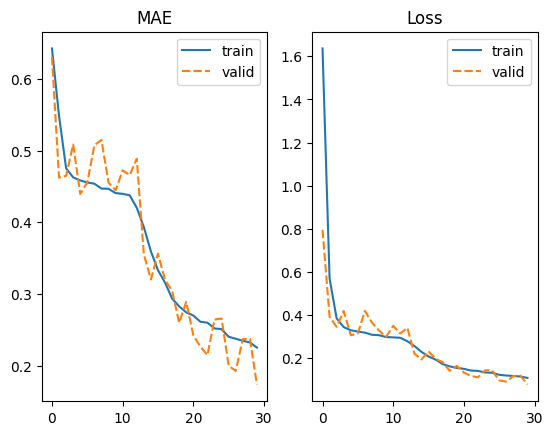

In [ ]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P2.history['mae']
mae_df['valid'] = his_model_time_P2.history['val_mae']
loss_df['train'] = his_model_time_P2.history['loss']
loss_df['valid'] = his_model_time_P2.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P2.evaluate(test_tx,  test_ty_period, verbose=2)

In [29]:
# print(test_ty[0:10])
pred_y_P2 = model_time_P2.predict(test_tx)
pred_P2 = period_to_clk(pred_y_P2)
print(test_ty[:3],pred_P2[:3])
np.mean(common_sense_err2(test_ty,pred_P2),axis = 0)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 0. 41.]
 [ 5. 58.]
 [ 6.  9.]]


array([0.13555556, 9.54055556])

Dual Regression, scaled

In [30]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_DR1 = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_DR1.summary()
print(model_time_DR1)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_DR1.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])
train_ty2 = np.array([train_ty[:,0]/11,train_ty[:,1]/59]).T
his_model_time_DR1 = model_time_DR1.fit(train_tx, train_ty2,
                                    epochs = 30, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,490 (1.78 MB)

 Trainable params: 467,042 (1.78 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30


456/456 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 2.5517 - mae: 0.4016 - val_loss: 0.7560 - val_mae: 0.3795 - learning_rate: 0.0010
Epoch 2/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.5020 - mae: 0.2619 - val_loss: 0.2369 - val_mae: 0.2203 - learning_rate: 0.0010
Epoch 3/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2103 - mae: 0.2310 - val_loss: 0.1385 - val_mae: 0.2171 - learning_rate: 0.0010
Epoch 4/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1309 - mae: 0.2245 - val_loss: 0.1043 - val_mae: 0.2175 - learning_rate: 0.0010
Epoch 5/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0995 - mae: 0.2181 - val_loss: 0.0872 - val_mae: 0.2132 - learning_rate: 0.0010
Epoch 6/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0892 - mae: 0.2195 - val_loss: 0.0815 - val_mae: 0.2134 - learning_rate: 0.0010
Epoch 7/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0834 - mae: 0.2193 - val_loss: 0.0771 - val_mae: 0.2116 - learning_rate: 0.0010
Epoch 8/30
456/4

57/57 - 0s - 4ms/step - loss: 0.0666 - mae: 0.2020


[0.06658356636762619, 0.2020273357629776]

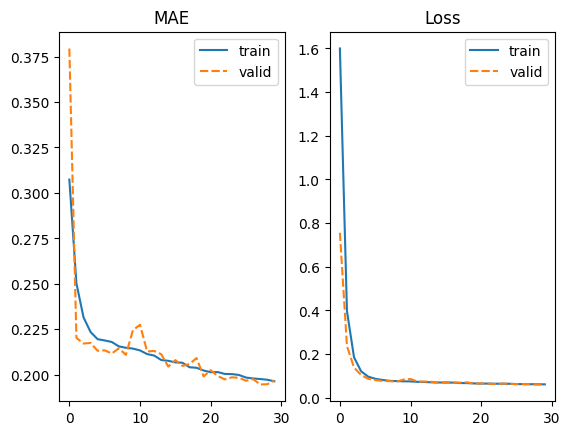

In [ ]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_DR1.history['mae']
mae_df['valid'] = his_model_time_DR1.history['val_mae']
loss_df['train'] = his_model_time_DR1.history['loss']
loss_df['valid'] = his_model_time_DR1.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE",xlabel='Epochs')
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss",xlabel='Epochs')
test_ty2 = np.array([test_ty[:,0]/11,test_ty[:,1]/59]).T
model_time_DR1.evaluate(test_tx,  test_ty2, verbose=2)

In [32]:
# print(test_ty[0:10])
pred_y_DR1 = model_time_DR1.predict(test_tx)
pred_DR1 = np.round(np.array([pred_y_DR1[:,0]*11,pred_y_DR1[:,1]*59]).T)
# pred_DR1 = np.round(pred_y_DR1)
print(test_ty[:3],pred_DR1[:3])
np.mean(common_sense_err2(test_ty,pred_DR1),axis = 0)
#array([ 1.41444444, 27.49444444])

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 6. 33.]
 [ 5. 29.]
 [ 4. 24.]]


array([ 1.47444444, 33.40055556])

Non scaled Dual regression

In [33]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_DR2 = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_DR2.summary()
print(model_time_DR2)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_DR2.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])
his_model_time_DR2 = model_time_DR2.fit(train_tx, train_ty,
                                    epochs = 30, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,490 (1.78 MB)

 Trainable params: 467,042 (1.78 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 191.7286 - mae: 9.8527 - val_loss: 484.0014 - val_mae: 15.1242 - learning_rate: 0.0010
Epoch 2/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 149.4959 - mae: 8.4317 - val_loss: 125.5256 - val_mae: 7.3565 - learning_rate: 0.0010
Epoch 3/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 132.8742 - mae: 7.7394 - val_loss: 136.4259 - val_mae: 7.8114 - learning_rate: 0.0010
Epoch 4/30
455/456 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 116.0869 - mae: 7.1585
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 116.0748 - mae: 7.1582 - val_loss: 196.2897 - val_mae: 9.1036 - learning_rate: 0.0010
Epoch 5/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 102.1153 - mae: 6.7079 - val_loss: 92.1493 - val_mae: 6.2212 - learning_rate: 7.5000e-04
Epoch 6/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 95.2661 - mae: 6

57/57 - 0s - 6ms/step - loss: 48.0458 - mae: 3.7030


[48.045799255371094, 3.7030141353607178]

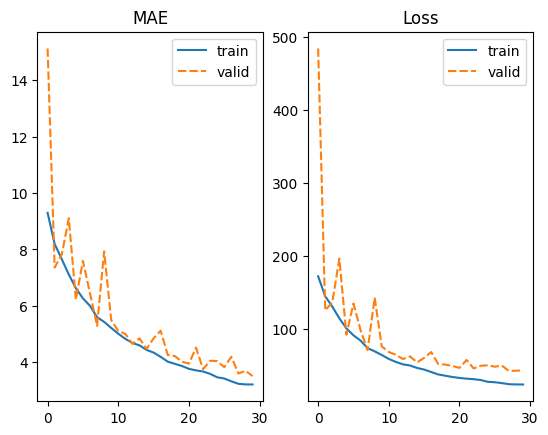

In [ ]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_DR2.history['mae']
mae_df['valid'] = his_model_time_DR2.history['val_mae']
loss_df['train'] = his_model_time_DR2.history['loss']
loss_df['valid'] = his_model_time_DR2.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_DR2.evaluate(test_tx,  test_ty, verbose=2)

In [35]:
# print(test_ty[0:10])
pred_y_DR2 = model_time_DR2.predict(test_tx)
pred_DR2 = np.round(np.array([pred_y_DR2[:,0],pred_y_DR2[:,1]]).T)
# pred_DR1 = np.round(pred_y_DR1)
print(test_ty[:3],pred_DR2[:3])
np.mean(common_sense_err2(test_ty,pred_DR2),axis = 0)
#array([ 1.41444444, 27.49444444])

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 6. 29.]
 [ 2. 53.]
 [ 4. 16.]]


array([ 1.35277778, 28.88111111])

150 x 150

In [36]:
time_x_L = np.load('images.npy')
time_y_L = np.load('labels.npy')
train_tx_L, test_tx_L, train_ty_L, test_ty_L = train_test_split(time_x_L, time_y_L, test_size=0.1, random_state=42)
train_ty_period_L = periodic_trans(train_ty_L)
test_ty_period_L = periodic_trans(test_ty_L)

In [37]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(2,name='min_y')(min_y)

model_time_MH2_L = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time_MH2_L.summary()
print(model_time_MH2_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_MH2_L.compile(optimizer=optimizer,
                       loss={'hr_y': loss_fn, 'min_y': 'mse'},
                       metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time_MH2_L = model_time_MH2_L.fit(train_tx_L, {'hr_y': train_ty_L[:,0], 'min_y': train_ty_period_L[:,2:]},
                                    epochs = 30, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 148, 148,  │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 148, 148,  │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │     36,896 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 36, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 34, 34,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 34,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 17, 17,    │          0 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 18496)     │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  2,367,616 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  2,367,616 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]   

 Total params: 4,810,222 (18.35 MB)

 Trainable params: 4,809,774 (18.35 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - hr_y_accuracy: 0.0762 - hr_y_loss: 2.7387 - loss: 10.7709 - min_y_loss: 3.2255 - min_y_mae: 0.9434 - val_hr_y_accuracy: 0.0864 - val_hr_y_loss: 2.4844 - val_loss: 4.4296 - val_min_y_loss: 0.5006 - val_min_y_mae: 0.6383 - learning_rate: 0.0010
Epoch 2/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - hr_y_accuracy: 0.0782 - hr_y_loss: 2.4899 - loss: 4.1611 - min_y_loss: 0.5003 - min_y_mae: 0.6358 - val_hr_y_accuracy: 0.0728 - val_hr_y_loss: 2.4891 - val_loss: 3.6606 - val_min_y_loss: 0.5000 - val_min_y_mae: 0.6374 - learning_rate: 0.0010
Epoch 3/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - hr_y_accuracy: 0.0852 - hr_y_loss: 2.4884 - loss: 3.5772 - min_y_loss: 0.5010 - min_y_mae: 0.6362 - val_hr_y_accuracy: 0.0815 - val_hr_y_loss: 2.5007 - val_loss: 3.3805 - val_min_y_loss: 0.5002 - val_min_y_mae: 0.6378 - learning_rate: 0.0010
Epoch 4/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - hr_y_acc

57/57 - 1s - 11ms/step - hr_y_accuracy: 0.0750 - hr_y_loss: 2.4855 - loss: 2.9854 - min_y_loss: 0.5000 - min_y_mae: 0.6372
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 0. 13.]
 [ 0. 13.]
 [ 0. 13.]]


array([ 2.55388889, 29.74111111])

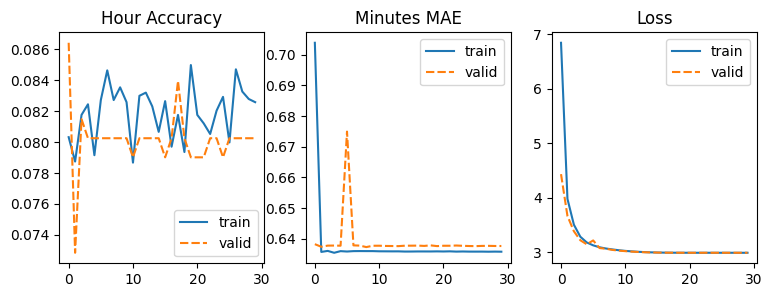

In [38]:
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time_MH2_L.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time_MH2_L.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time_MH2_L.history['min_y_mae']
min_mae_df['valid'] = his_model_time_MH2_L.history['val_min_y_mae']
loss_df['train'] = his_model_time_MH2_L.history['loss']
loss_df['valid'] = his_model_time_MH2_L.history['val_loss']
fig, axs = plt.subplots(ncols=3,nrows=1,figsize=(9,3))
# plt.figure(figsize=(6,15))
sns.lineplot(hr_acc_df,ax=axs[0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[2]).set_title("Loss")
# axs[1, 1].axis('off')
model_time_MH2_L.evaluate(test_tx_L,  {'hr_y': test_ty_L[:, 0], 'min_y':test_ty_period_L[:,2:] }, verbose=2)
# print(test_ty[0:10])
pred_hr_MH2_L,pred_min_MH2_L = model_time_MH2_L.predict(test_tx_L)
pred_hr_MH2_L[:10],pred_min_MH2_L[:10]
hr_MH2_L = np.argmax(tf.nn.softmax(pred_hr_MH2_L),axis=1)
min_MH2_L = period_to_hrmin(pred_min_MH2_L,60)
hr_MH2_L[:10],min_MH2_L[:10]
pred_MH2_L = np.array([hr_MH2_L,min_MH2_L]).T
print(test_ty_L[:3],pred_MH2_L[:3])
np.mean(common_sense_err2(test_ty_L,pred_MH2_L),axis = 0)

In [39]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(2,name='min_y')(min_y)

model_time_MH2_L = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time_MH2_L.summary()
print(model_time_MH2_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_MH2_L.compile(optimizer=optimizer,
                       loss={'hr_y': loss_fn, 'min_y': 'mse'},
                       metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time_MH2_L = model_time_MH2_L.fit(train_tx_L, {'hr_y': train_ty_L[:,0], 'min_y': train_ty_period_L[:,2:]},
                                    epochs = 30, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 148, 148,  │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 148, 148,  │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │     36,896 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 36, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 34, 34,    │      9,248 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 34,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 15, 15,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 7, 7, 64)  │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    401,536 │ flatten[0][0]   

 Total params: 887,438 (3.39 MB)

 Trainable params: 886,926 (3.38 MB)

 Non-trainable params: 512 (2.00 KB)

<Functional name=functional, built=True>
Epoch 1/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - hr_y_accuracy: 0.0836 - hr_y_loss: 2.5654 - loss: 7.1429 - min_y_loss: 0.7485 - min_y_mae: 0.6828 - val_hr_y_accuracy: 0.0809 - val_hr_y_loss: 2.4851 - val_loss: 3.6026 - val_min_y_loss: 0.4638 - val_min_y_mae: 0.6073 - learning_rate: 0.0010
Epoch 2/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - hr_y_accuracy: 0.1007 - hr_y_loss: 2.4687 - loss: 3.3027 - min_y_loss: 0.3424 - min_y_mae: 0.4935 - val_hr_y_accuracy: 0.1253 - val_hr_y_loss: 2.4358 - val_loss: 3.1314 - val_min_y_loss: 0.4191 - val_min_y_mae: 0.5322 - learning_rate: 0.0010
Epoch 3/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - hr_y_accuracy: 0.1750 - hr_y_loss: 2.1934 - loss: 2.7338 - min_y_loss: 0.2796 - min_y_mae: 0.4363 - val_hr_y_accuracy: 0.1222 - val_hr_y_loss: 3.7432 - val_loss: 4.5420 - val_min_y_loss: 0.5445 - val_min_y_mae: 0.6111 - learning_rate: 0.0010
Epoch 4/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - hr_y_accu

57/57 - 1s - 10ms/step - hr_y_accuracy: 0.8533 - hr_y_loss: 0.3738 - loss: 0.6115 - min_y_loss: 0.0305 - min_y_mae: 0.1367


[0.611497163772583,
 0.37376150488853455,
 0.030521253123879433,
 0.8533333539962769,
 0.13667677342891693]

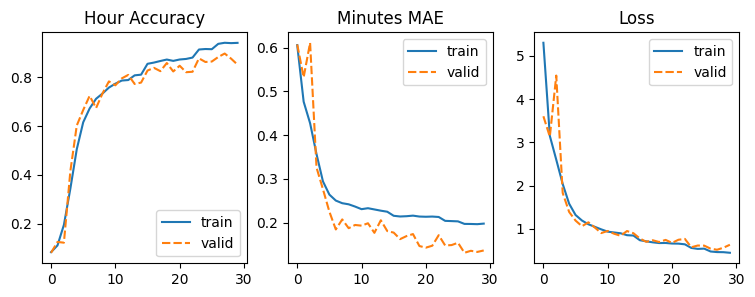

In [40]:
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time_MH2_L.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time_MH2_L.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time_MH2_L.history['min_y_mae']
min_mae_df['valid'] = his_model_time_MH2_L.history['val_min_y_mae']
loss_df['train'] = his_model_time_MH2_L.history['loss']
loss_df['valid'] = his_model_time_MH2_L.history['val_loss']
fig, axs = plt.subplots(ncols=3,nrows=1,figsize=(9,3))
# plt.figure(figsize=(6,15))
sns.lineplot(hr_acc_df,ax=axs[0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[2]).set_title("Loss")
# axs[1, 1].axis('off')
model_time_MH2_L.evaluate(test_tx_L,  {'hr_y': test_ty_L[:, 0], 'min_y':test_ty_period_L[:,2:] }, verbose=2)

In [41]:
# print(test_ty[0:10])
pred_hr_MH2_L,pred_min_MH2_L = model_time_MH2_L.predict(test_tx_L)
pred_hr_MH2_L[:10],pred_min_MH2_L[:10]
hr_MH2_L = np.argmax(tf.nn.softmax(pred_hr_MH2_L),axis=1)
min_MH2_L = period_to_hrmin(pred_min_MH2_L,60)
hr_MH2_L[:10],min_MH2_L[:10]
pred_MH2_L = np.array([hr_MH2_L,min_MH2_L]).T
print(test_ty_L[:3],pred_MH2_L[:3])
np.mean(common_sense_err2(test_ty_L,pred_MH2_L),axis = 0)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 0. 42.]
 [ 5. 59.]
 [ 6. 11.]]


array([0.07222222, 6.09222222])

In [42]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_P1_L = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P1_L.summary()
print(model_time_P1_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P1_L.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P1_L = model_time_P1_L.fit(train_tx_L, single_angle_trans(train_ty_L),
                                    epochs = 30, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,367,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,433,570 (9.28 MB)

 Trainable params: 2,433,122 (9.28 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - loss: 7.4231 - mae: 1.0735 - val_loss: 1.8926 - val_mae: 0.6347 - learning_rate: 0.0010
Epoch 2/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 1.6720 - mae: 0.6381 - val_loss: 1.2208 - val_mae: 0.6351 - learning_rate: 0.0010
Epoch 3/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 1.1362 - mae: 0.6365 - val_loss: 0.9401 - val_mae: 0.6353 - learning_rate: 0.0010
Epoch 4/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.8957 - mae: 0.6362 - val_loss: 0.7892 - val_mae: 0.6353 - learning_rate: 0.0010
Epoch 5/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.7654 - mae: 0.6377 - val_loss: 0.7007 - val_mae: 0.6353 - learning_rate: 0.0010
Epoch 6/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.6867 - mae: 0.6369 - val_loss: 0.6474 - val_mae: 0.6353 - learning_rate: 0.0010
Epoch 7/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.6418 - mae: 0.6367 - val_loss: 

57/57 - 1s - 9ms/step - loss: 0.5000 - mae: 0.6369
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[11. 53.]
 [11. 53.]
 [11. 53.]]


array([ 2.55      , 30.03666667])

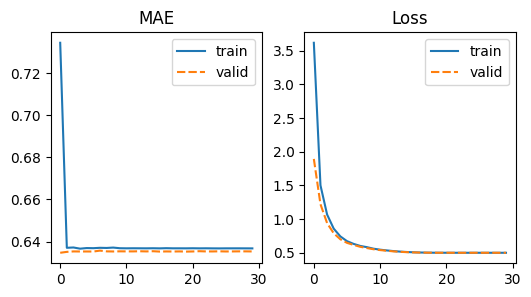

In [43]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P1_L.history['mae']
mae_df['valid'] = his_model_time_P1_L.history['val_mae']
loss_df['train'] = his_model_time_P1_L.history['loss']
loss_df['valid'] = his_model_time_P1_L.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P1_L.evaluate(test_tx_L,  single_angle_trans(test_ty_L), verbose=2)
# print(test_ty[0:10])
pred_y_P1_L = model_time_P1_L.predict(test_tx_L)
pred_P1_L = s_ang_to_clk(pred_y_P1_L)
print(test_ty_L[:3],pred_P1_L[:3])
np.mean(common_sense_err2(test_ty_L,pred_P1_L),axis = 0)

In [44]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_P1_L = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P1_L.summary()
print(model_time_P1_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P1_L.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P1_L = model_time_P1_L.fit(train_tx_L, single_angle_trans(train_ty_L),
                                    epochs = 30, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 476,866 (1.82 MB)

 Trainable params: 476,354 (1.82 MB)

 Non-trainable params: 512 (2.00 KB)

<Functional name=functional, built=True>
Epoch 1/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - loss: 3.1081 - mae: 0.6931 - val_loss: 1.1616 - val_mae: 0.5680 - learning_rate: 0.0010
Epoch 2/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.9142 - mae: 0.4826 - val_loss: 0.5447 - val_mae: 0.4416 - learning_rate: 0.0010
Epoch 3/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.4292 - mae: 0.3629 - val_loss: 0.2995 - val_mae: 0.3381 - learning_rate: 0.0010
Epoch 4/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.2514 - mae: 0.2919 - val_loss: 0.2622 - val_mae: 0.3423 - learning_rate: 0.0010
Epoch 5/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.1844 - mae: 0.2622 - val_loss: 0.1668 - val_mae: 0.2586 - learning_rate: 0.0010
Epoch 6/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.1472 - mae: 0.2385 - val_loss: 0.1028 - val_mae: 0.1816 - learning_rate: 0.0010
Epoch 7/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.1253 - mae: 0.2235 - val_loss: 

57/57 - 0s - 8ms/step - loss: 0.0316 - mae: 0.1014
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 1. 37.]
 [ 5. 12.]
 [ 5. 58.]]


array([2.77777778e-03, 1.22166667e+01])

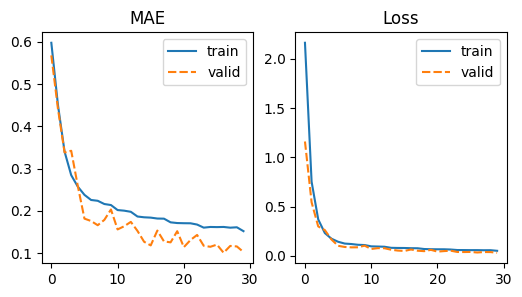

In [45]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P1_L.history['mae']
mae_df['valid'] = his_model_time_P1_L.history['val_mae']
loss_df['train'] = his_model_time_P1_L.history['loss']
loss_df['valid'] = his_model_time_P1_L.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P1_L.evaluate(test_tx_L,  single_angle_trans(test_ty_L), verbose=2)
# print(test_ty[0:10])
pred_y_P1_L = model_time_P1_L.predict(test_tx_L)
pred_P1_L = s_ang_to_clk(pred_y_P1_L)
print(test_ty_L[:3],pred_P1_L[:3])
np.mean(common_sense_err2(test_ty_L,pred_P1_L),axis = 0)

In [46]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(4)(x)

model_time_P2_L = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P2_L.summary()
print(model_time_P2_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P2_L.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P2_L = model_time_P2_L.fit(train_tx_L, train_ty_period_L,
                                    epochs = 30, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,367,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,433,700 (9.28 MB)

 Trainable params: 2,433,252 (9.28 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - loss: 5.1907 - mae: 0.8878 - val_loss: 1.5924 - val_mae: 0.6311 - learning_rate: 0.0010
Epoch 2/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 1.3957 - mae: 0.6309 - val_loss: 0.9887 - val_mae: 0.6276 - learning_rate: 0.0010
Epoch 3/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.9007 - mae: 0.6056 - val_loss: 0.6787 - val_mae: 0.5488 - learning_rate: 0.0010
Epoch 4/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.6483 - mae: 0.5389 - val_loss: 0.6073 - val_mae: 0.5438 - learning_rate: 0.0010
Epoch 5/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.5271 - mae: 0.5060 - val_loss: 0.5025 - val_mae: 0.5026 - learning_rate: 0.0010
Epoch 6/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.4653 - mae: 0.4907 - val_loss: 0.4046 - val_mae: 0.4682 - learning_rate: 0.0010
Epoch 7/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.4320 - mae: 0.4845 - val_loss: 

57/57 - 1s - 9ms/step - loss: 0.2981 - mae: 0.4454
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[10. 52.]
 [ 1. 10.]
 [ 3. 15.]]


array([ 0.95833333, 39.21      ])

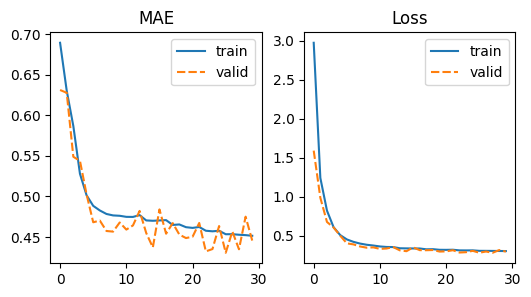

In [47]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P2_L.history['mae']
mae_df['valid'] = his_model_time_P2_L.history['val_mae']
loss_df['train'] = his_model_time_P2_L.history['loss']
loss_df['valid'] = his_model_time_P2_L.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P2_L.evaluate(test_tx_L,  test_ty_period_L, verbose=2)
# print(test_ty[0:10])
pred_y_P2_L = model_time_P2_L.predict(test_tx_L)
pred_P2_L = period_to_clk(pred_y_P2_L)
print(test_ty_L[:3],pred_P2_L[:3])
np.mean(common_sense_err2(test_ty_L,pred_P2_L),axis = 0)

In [48]:
print(np.mean(common_sense_err2(test_ty_L[10:20],pred_P2_L[10:20]),axis = 0))
test_ty_L[10:20],pred_P2_L[10:20]

[ 1.  45.1]


(array([[11, 25],
        [10, 15],
        [ 7, 46],
        [ 5,  1],
        [ 1, 44],
        [ 6, 56],
        [ 4, 15],
        [ 3, 55],
        [ 3, 18],
        [ 6, 52]]),
 array([[ 2., 12.],
        [ 1.,  7.],
        [ 8., 42.],
        [ 3., 17.],
        [11., 54.],
        [ 9., 49.],
        [ 3., 16.],
        [ 1., 10.],
        [ 3., 17.],
        [ 7., 36.]]))